### Odysseas Sofikitis, 10130, sodyssea@ece.auth.gr
### Tompulidis Romanos, 10041, romanost@ece.auth.gr

# Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(filename, size):
    ## load data
    data_file = pd.read_csv(filename, header=None)
    data_file = data_file.dropna()

    # make train and test sets
    data_x = np.array(data_file.drop(data_file.columns[-1], axis=1))
    data_y = np.array(data_file[data_file.columns[-1]])

    train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                        test_size=size,
                                                        stratify=data_y,
                                                        random_state=42)

    return train_x, test_x, train_y, test_y


In [5]:
# decide on pca components
from sklearn.decomposition import PCA
import plotly.graph_objects as go

def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values

    return X_aux

df = pd.read_csv("./datasetC.csv", header=None)

pca = PCA()
pca.fit(df)
original_variance = pca.explained_variance_ratio_

N_permutations = 100
variance = np.zeros((N_permutations, len(df.columns)))

# permutation test to establish correlation (or not) between features
for i in range(N_permutations):
    X_aux = de_correlate_df(df)

    pca.fit(X_aux)
    variance[i, :] = pca.explained_variance_ratio_

# hold PCs with explained_variance less than the original
p_val = np.sum(variance > original_variance, axis=0) / N_permutations
num_components = next(i for i, value in enumerate(p_val) if value > 0) - 1
print(f"No. PCA-Components:{num_components}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df.columns))], y=p_val, name='p-value on significance'))
fig.update_layout(title="PCA Permutation Test p-values")

No. PCA-Components:25


In [3]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(train_x, test_x, train_y, pca_components=None):
    # normalize
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    if pca_components:
        # pca for outliers
        pca = PCA(n_components=num_components)
        x_pca = pca.fit_transform(train_x)

        x_reconstructed = pca.inverse_transform(x_pca)
        reconstruction_errors = np.linalg.norm(train_x - x_reconstructed, axis=1)

        threshold = np.percentile(reconstruction_errors, 99.95)

        train_x = train_x[reconstruction_errors <= threshold]
        train_y = train_y[reconstruction_errors <= threshold]

    if pca_components:
        # pca for dimensionality
        pca = PCA(n_components=pca_components)
        train_x = pca.fit_transform(train_x)
        test_x = pca.transform(test_x)

    return train_x, test_x, train_y

# Other Models

## k-NN

### Cross-Validation

In [9]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import KNeighborsClassifier
#
## loading data
#train_x, test_x, train_y, test_y = load_data("./datasetC.csv", 0.2)
#
#train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)
#
#
## grid search
#params = {
#    'n_neighbors': [2, 4, 8, 16, 32],
#    'weights': ['uniform', 'distance'],
#}
#
#model = KNeighborsClassifier()
#
#grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
#grid.fit(train_x, train_y)
#print("Best parameters:", grid.best_params_)
#
#best_model = grid.best_estimator_

Best parameters: {'n_neighbors': 16, 'weights': 'distance'}


### Results

Accuracy: 88.00%


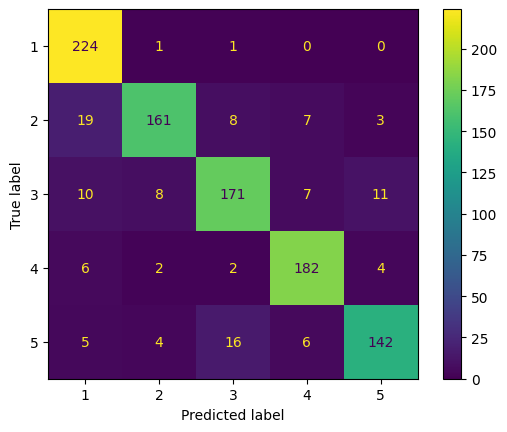

In [10]:
#from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
#from matplotlib import pyplot as plt
#
#
## test model
#pred_y = best_model.predict(test_x)
#
## evaluate the performance of the model
#accuracy = accuracy_score(test_y, pred_y)
#ConfusionMatrixDisplay.from_predictions(test_y, pred_y)
#
#print(f'Accuracy: {100*accuracy:.2f}%')
#plt.show()
#

## MLP

### The network

In [11]:
#import torch.nn as nn
#
#class Network(nn.Module):
#    def __init__(self, hidden_dim, input_dim, output_dim):
#        super().__init__()
#        self.flatten = nn.Flatten()
#
#        layers = []
#        sizes = [input_dim] + hidden_dim + [output_dim]
#
#        for i in range(len(sizes) - 1):
#            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
#            if i < len(sizes) - 2:
#                layers.append(nn.ReLU())
#
#        self.linear_relu_stack = nn.Sequential(*layers)
#
#    def forward(self, x):
#        x = self.flatten(x)
#        x = self.linear_relu_stack(x)
#        return x
#
#batch_size = 32

### Train & Test

In [14]:
#def train_loop(model, dataloader, loss_function, optimizer, device):
#    for batch, (X, y) in enumerate(dataloader):
#        X = X.to(device)
#        y = y.to(device)
#
#        pred = model(X)
#        loss = loss_function(pred, y)
#
#        optimizer.zero_grad()
#        loss.backward()
#        optimizer.step()
#    return

In [15]:
#def test(model, dataloader, device, return_accuracy=False):
#    size = len(dataloader) * batch_size
#    correct = 0
#
#    model.eval()
#    with torch.no_grad():
#        for X, y in dataloader:
#
#            X = X.to(device)
#            y = y.to(device)
#
#            pred = model(X)
#            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
#
#    correct /= size
#
#    if return_accuracy:
#      return 100 * correct

### Preprocess Data

In [16]:
#import torch
#from torch.utils.data import DataLoader, TensorDataset
#
#train_x, test_x, train_y, test_y = load_data("./datasetC.csv", 0.2)
#train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)
#
#train_x = np.float32(train_x)
#test_x = np.float32(test_x)
#train_y = train_y - 1
#test_y = test_y - 1
#
#train_x = torch.from_numpy(train_x)
#test_x = torch.from_numpy(test_x)
#train_y = torch.from_numpy(train_y)
#test_y = torch.from_numpy(test_y)
#
#train_dataset = TensorDataset(train_x, train_y)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataset = TensorDataset(test_x, test_y)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"Using {device} device")

Using cuda device


### GridSearch

In [18]:
#input_dim = train_x.shape[1]
#output_dim = max(train_y) + 1
#
#hidden_dims = [input_dim // 2, 2 * output_dim]
#learning_rates = [1e-3, 1e-4, 1e-5]
#epochs = 100
#
#loss_function = nn.CrossEntropyLoss()
#
#best_accuracy = 0.0
#best_params = {}
#for lr in learning_rates:
#    print(f'-----Learning Rate={lr}------')
#
#    model = Network(hidden_dims, input_dim, output_dim).to(device)
#    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#
#    for epoch in range(1, epochs + 1):
#        train_loop(model, train_loader, loss_function, optimizer, device)
#
#        accuracy = test(model, test_loader, device, return_accuracy=True)
#        if accuracy > best_accuracy:
#            best_accuracy = accuracy
#            best_params = {'learning_rate': lr, 'epochs': epoch}
#            torch.save(model.state_dict(), 'best_model.pth')
#
#        if epoch % 20 == 0:
#            print(f'Epoch {epoch}')
#            print(f"Test Error: \n Accuracy: {accuracy:.2f}%\n")
#
#print("\nTraining completed!")
#print("\nBest parameters:", best_params)

-----Learning Rate=0.001------
Epoch 20
Test Error: 
 Accuracy: 84.47%

Epoch 40
Test Error: 
 Accuracy: 85.55%

Epoch 60
Test Error: 
 Accuracy: 85.35%

Epoch 80
Test Error: 
 Accuracy: 84.96%

Epoch 100
Test Error: 
 Accuracy: 85.06%

-----Learning Rate=0.0001------
Epoch 20
Test Error: 
 Accuracy: 77.15%

Epoch 40
Test Error: 
 Accuracy: 81.15%

Epoch 60
Test Error: 
 Accuracy: 81.45%

Epoch 80
Test Error: 
 Accuracy: 82.91%

Epoch 100
Test Error: 
 Accuracy: 83.50%

-----Learning Rate=1e-05------
Epoch 20
Test Error: 
 Accuracy: 14.26%

Epoch 40
Test Error: 
 Accuracy: 18.36%

Epoch 60
Test Error: 
 Accuracy: 26.76%

Epoch 80
Test Error: 
 Accuracy: 36.43%

Epoch 100
Test Error: 
 Accuracy: 42.19%


Training completed!

Best parameters: {'learning_rate': 0.001, 'epochs': 41}


### Final Results

In [ ]:
#print("Load the best model")
#best_model = Network(hidden_dims, input_dim, output_dim).to(device)
#best_model.load_state_dict(torch.load('best_model.pth'))
#
#accuracy = test(best_model, test_loader, device, return_accuracy=True)
#print(f"Final accuracy: {accuracy:.2f}%\n")
#

Load the best model
Final accuracy: 86.13%



# SVM

## Cross-Validation

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# loading data
train_x, test_x, train_y, test_y = load_data("./datasetC.csv", 0.2)

train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)


# grid search
params = {
    'C': [1.0, 10.0, 100.0],
    'gamma': ['auto', 'scale']
}

model = SVC(random_state=42)

grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(train_x, train_y)
print("Best parameters:", grid.best_params_)

best_model = grid.best_estimator_

Best parameters: {'C': 1.0, 'gamma': 'auto'}


## Results

Accuracy: 91.40%


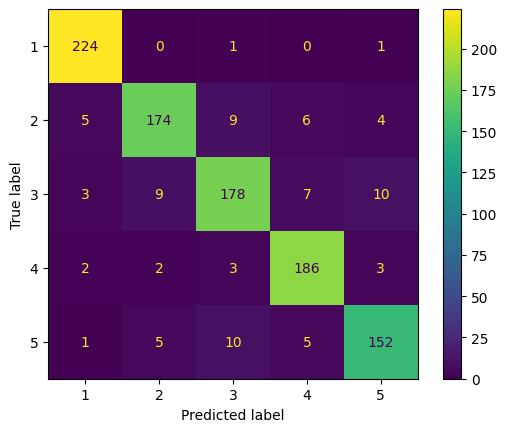

In [31]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# test model
pred_y = best_model.predict(test_x)

# evaluate the performance of the model
accuracy = accuracy_score(test_y, pred_y)
ConfusionMatrixDisplay.from_predictions(test_y, pred_y)

print(f'Accuracy: {100*accuracy:.2f}%')
plt.show()


## Test Data

In [32]:
train_x, test_x, train_y, test_y = load_data("./datasetC.csv", 0.2)

test_data = pd.read_csv('./datasetCTest.csv', header=None)
test_x = np.array(test_data)

train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)

pred = best_model.predict(test_x)

np.save('./labels37.npy', pred)

In [34]:
labels = np.load('labels37.npy')

[5 2 4 1 4 1 2 5 3 4 3 5 1 2 1 5 5 3 5 1 4 5 5 1 1 2 2 3 2 2 2 2 2 1 2 2 3
 5 3 3 1 3 2 4 4 2 1 5 2 4 3 2 1 2 1 3 2 3 2 4 1 1 3 2 1 3 3 1 5 4 1 4 3 1
 1 2 4 3 5 1 1 5 4 4 1 3 5 4 5 2 4 2 3 3 2 4 3 2 4 3 4 1 1 4 5 5 2 4 3 1 5
 5 1 4 5 3 2 5 3 4 2 1 1 1 4 5 3 2 5 2 1 3 5 1 2 1 2 1 4 2 4 4 2 4 3 5 2 1
 4 2 3 1 2 3 3 3 4 5 4 1 1 1 2 3 4 4 5 2 3 1 1 1 2 2 3 5 4 5 1 1 5 5 3 3 4
 3 4 5 1 3 5 3 2 1 3 2 1 2 3 1 3 1 2 1 3 3 3 2 3 5 4 5 2 4 5 1 1 5 3 3 1 1
 4 4 4 2 5 4 4 1 3 2 2 2 3 4 5 5 3 4 2 5 1 2 4 5 1 5 3 2 1 1 3 4 4 2 3 2 2
 5 1 5 1 5 1 5 4 2 3 1 4 4 1 1 5 2 1 3 4 4 2 5 1 1 2 2 3 5 4 5 4 5 1 1 2 3
 3 4 3 5 4 1 2 4 2 4 1 4 1 2 4 4 4 3 4 4 4 4 4 4 5 3 5 1 3 2 1 5 1 5 3 1 3
 1 4 2 1 1 3 3 3 4 2 4 1 1 2 2 4 1 4 4 3 2 2 5 4 2 1 1 2 1 2 4 3 3 3 2 4 2
 5 1 3 3 3 5 5 4 3 4 3 3 5 3 2 4 5 3 2 5 4 3 4 1 2 3 4 5 3 5 2 1 5 2 3 4 5
 4 3 5 1 2 2 3 3 4 3 5 4 1 1 1 4 2 3 4 3 4 4 1 3 1 4 4 5 3 3 5 1 3 3 5 1 1
 3 4 5 1 5 3 1 2 4 3 3 5 5 1 4 4 1 4 2 3 1 4 1 4 2 1 4 5 2 4 5 2 1 2 4 3 5
 2 5 2 4 5 2 4 3 4 1 2 2 